### Step 0: Importing necessary libraries

In [32]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

### Step 1: Reading the dataset

For this excercise, I used a restaurant revenue dataset. Each row contains one restaurant, and details of the restaurant. The aim of the model will be to predict a restaurant's revenue based on these details such as average customer spending, cuisine type, marketing spend and reviews.

In [53]:
df = pd.read_csv("Restaurant_revenue.csv")

print("The first 5 rows of the dataset:")
display(df.head(5))

The first 5 rows of the dataset:


,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763
3,70,43.005307,4.416053,Italian,18.984098,1,59,348.190573
4,30,17.456199,3.475052,Italian,12.766143,1,30,185.009121


### Step 2: Cleaning up the dataset

As we can see, the column *Cuisine_Type* is categorical with 4 possible values:

In [51]:
df["Cuisine_Type"].unique()

array(['Japanese', 'Italian', 'American', 'Mexican'], dtype=object)

I also checked if the dataset has any null values. Fortunatelly, every cell has some data:

In [52]:
print("\nChecking the number of null values:\n")
df.info()


Checking the number of null values:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Number_of_Customers        1000 non-null   int64  
 1   Menu_Price                 1000 non-null   float64
 2   Marketing_Spend            1000 non-null   float64
 3   Cuisine_Type               1000 non-null   object 
 4   Average_Customer_Spending  1000 non-null   float64
 5   Promotions                 1000 non-null   int64  
 6   Reviews                    1000 non-null   int64  
 7   Monthly_Revenue            1000 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 62.6+ KB


To handle the *Cuisine_Type* column correctly, I used OneHotEncoder to turn it into boolean (int values with 0 or 1 to be exact) columns.

In [54]:
from sklearn.preprocessing import OneHotEncoder

variables = ['Cuisine_Type']

encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

df.head()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,Cuisine_Type_American,Cuisine_Type_Italian,Cuisine_Type_Japanese,Cuisine_Type_Mexican
0,61,43.117635,12.663793,36.236133,0,45,350.912040,0,0,1,0
1,24,40.020077,4.577892,17.952562,0,36,221.319091,0,1,0,0
2,81,41.981485,4.652911,22.600420,1,91,326.529763,0,0,1,0
3,70,43.005307,4.416053,18.984098,1,59,348.190573,0,1,0,0
4,30,17.456199,3.475052,12.766143,1,30,185.009121,0,1,0,0


### Step 3: Train/test/validation split
I split the dataset into 3 parts: 70% will be the training data, 15% the test data and another 15% the validation data.

c:\Users\zsolt\OneDrive - Óbudai egyetem\Deep Learning\deeplearning\.venv\Lib\site-packages\skfeature\function\similarity_based\fisher_score.py:59: RuntimeWarning: divide by zero encountered in divide
  score = 1.0 / lap_score - 1


<Axes: >

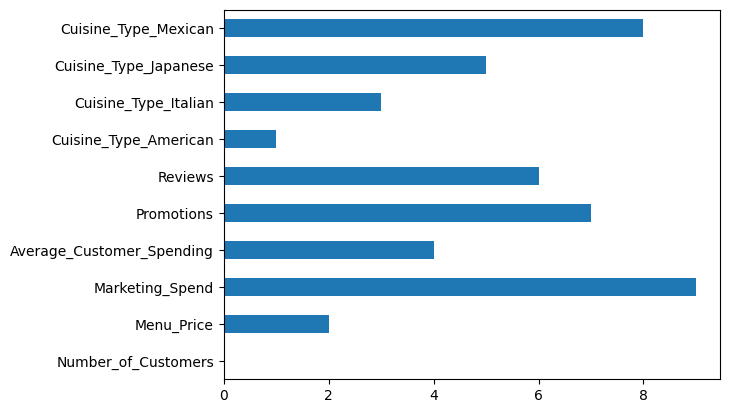

In [ ]:
X = df.drop(columns="Monthly_Revenue")
y = df["Monthly_Revenue"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

#df.corr(numeric_only=True)

from skfeature.function.similarity_based import fisher_score

# Convert boolean columns to integers for Fisher Score
X_numeric = X.copy()
for col in X_numeric.select_dtypes(include='bool').columns:
	X_numeric[col] = X_numeric[col].astype(int)

# get the fisher's score rankings 
ranks = fisher_score.fisher_score(X_numeric.values, y.values)

# create a pandas DataFrame for easier interpretation
feat_importances = pd.Series(ranks, X.columns)
feat_importances.plot(kind='barh')

### Step 4: Creating neural network

After experimenting, the best result I could achieve was with this model made out of mostly dense layers. In the input I used a normalization layer so that the model can predict better. I also applied a droput layer as an optimization to lower the overfitting.

In [36]:
variable_amount = len(X.columns)

model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(18, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.01)),
        layers.Dropout(0.1),
        layers.Dense(8, activation="relu"),
        layers.Dense(12, activation="relu"),
        layers.Dense(1)
    ]
)

model.compile(optimizer='adam', loss='mse')
model.summary()

c:\Users\zsolt\OneDrive - Óbudai egyetem\Deep Learning\deeplearning\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 18)             │           198 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 12)             │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 511 (2.00 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 20 (80.00 B)

### Step 5: Fitting data to neural network
It's time to fit the training data to the neural network. Then we check with a plot how the training loss changes. Fortunately, it shows a constantly decreasing trend.

Epoch 1/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 82871.1406 - val_loss: 78208.7500
Epoch 2/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 82475.0547 - val_loss: 77618.5234
Epoch 3/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 81800.6406 - val_loss: 76747.1172
Epoch 4/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 80546.3672 - val_loss: 75223.1719
Epoch 5/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 78201.0078 - val_loss: 72440.3594
Epoch 6/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 74165.0625 - val_loss: 67776.6562
Epoch 7/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 67657.7344 - val_loss: 60458.4727
Epoch 8/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 57934.6289 - val_loss: 49451.4531
Epoch 9/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 44818.6875 - val_loss: 35540.5117
Epoch 10/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30891.1895 - val_loss: 22482.4434
Epoch 11/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - los

<Axes: >

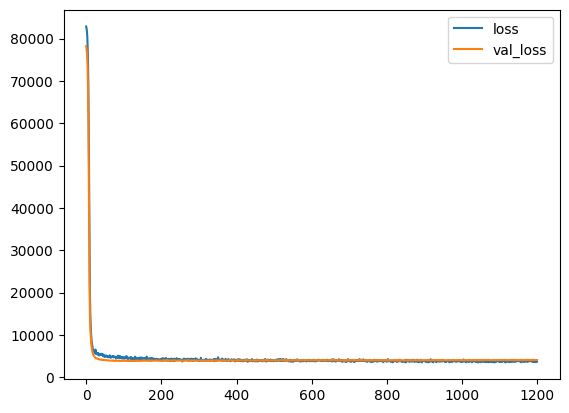

In [ ]:
model.fit(x=X_train, y=y_train, epochs=1200, validation_data=(X_val, y_val))

loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

Now I use the test data to see how well the model works. Using a scatter plot I compare the predicted values with the test values.

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000012D03DD6A20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

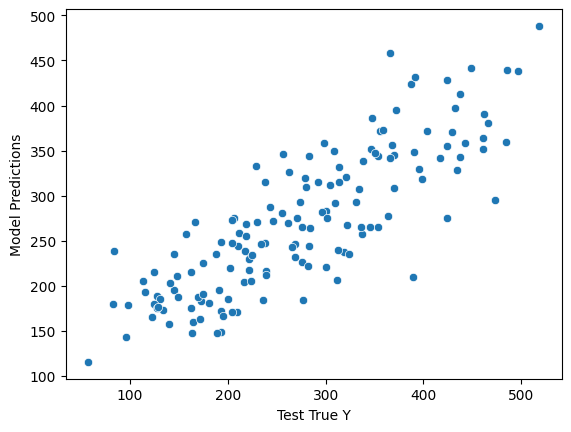

In [38]:

# get test predictions
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

Then I visualize how well the prediction distribution follows the normal distribution.

C:\Users\zsolt\AppData\Local\Temp\ipykernel_28160\1091839839.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


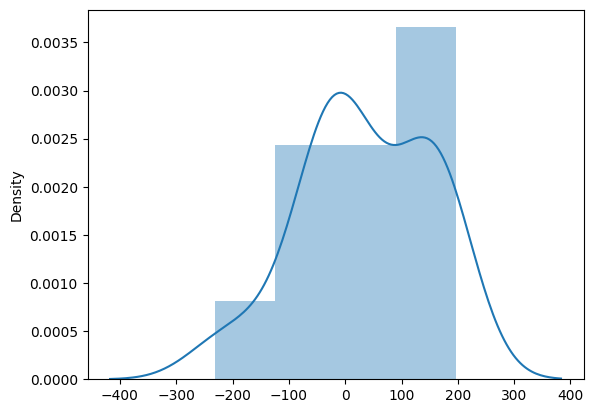

In [ ]:
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

### Step 6: Metrics
Using some metrics, we can measure how well the model describes the original dataset.

In [40]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
47.66 $

MSE
3549.44 $^2

RMSE:
59.58 $

R-squared:
0.68

Explained variance score:
0.68


### Step 7: Using the model to predict with imaginary new values

In [60]:
tester_row = {
    'Number_of_Customers': 53,
    'Menu_Price': 33.25,
    'Marketing_Spend': 12.4,
    'Average_Customer_Spending': 15.5,
    'Promotions': 1,
    'Reviews': 40,
    'Cuisine_Type_American': 0,
    'Cuisine_Type_Italian': 1,
    'Cuisine_Type_Japanese': 0,
    'Cuisine_Type_Mexican': 0
}

tester_row = pd.DataFrame([tester_row])

result = model.predict(tester_row)[0]

print("\nEstimated restaurant revenue with the given numbers:")
print(f"$ {round(float(result[0]), 2)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Estimated restaurant revenue with the given numbers:
$ 275.18


### Step 8: Conclusion
In my opinion, restaurant revenue can be influenced by many things, therefore it is hard to predict it exactly. (although this example contains data about average spending, nr. customers etc.) Because of that, I am satisfied with the results I got, I expected much worse. The results could be even more optimized if some of the unnecessary columns were removed.
This model could help restaurants to calculate their revenue for the next month based on the prevous ones.

In [61]:
#pip install tk
import tkinter as tk

root = tk.Tk()
root.geometry("500x500")
root.title("ANN for regression")

label = tk.Label(root, text="Teszt")
label.pack()

button = tk.Button(root, text="gomb", function=print("asd"))
button.pack()

tk.mainloop()



asd
